In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

# 本当にこれは効くのか？
import autosklearn.classification

データ詳細(生データ)

| Variable | Definition | Key |
|:-------:|:---|:----|
|survived | Survival | 0 = No, 1 = Yes |
|Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Name | name | |
|Sex| Sex | |
|Age | Age in years | | 
|SibSp | # of siblings / spouses aboard the Titanic	| |
|Parch | # of parents / children aboard the Titanic	| |
|Ticket | Ticket number | |
|Fare | Passenger fare | |
|Cabin | Cabin number | |
|Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

In [2]:
train_df=pd.read_csv("../data/raw/train.csv")
test_df=pd.read_csv("../data/raw/test.csv")
combine=[train_df, test_df]

とりあえず性別を数値化

In [3]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

名前の敬称を抜き出してみる

In [4]:
train_df["Title"]=train_df.Name.str.extract("([A-Za-z]+)\.")
test_df["Title"]=train_df.Name.str.extract("([A-Za-z]+)\.")
train_df["Title"].value_counts()

/Users/syo-oco/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
/Users/syo-oco/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Lady          1
Sir           1
Countess      1
Capt          1
Ms            1
Jonkheer      1
Mme           1
Don           1
Name: Title, dtype: int64

In [5]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess',\
 	'Don', 'Jonkheer'], 'Noble')
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col',\
 	'Dr', 'Major', 'Rev', 'Sir'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [6]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5, "Noble":6}
for x in combine:
    x['Title'] =x['Title'].replace(title_mapping)

In [7]:
freq = train_df.Embarked.dropna().mode()[0]
port_mapping={"C":0, "Q":1, "S":2}
for dataset in combine:
    dataset["Embarked"]=dataset["Embarked"].fillna(freq)
    dataset["Embarked"]=dataset["Embarked"].map(port_mapping)

In [8]:
for j in train_df.Title.unique():
    guess_med=train_df[
             (train_df['Title'] == j)]['Age'].dropna().median()
    train_df.loc[(train_df.Age.isnull()) & (train_df.Title==j),"Age"]=int(guess_med)
    test_df.loc[(test_df.Age.isnull()) & (test_df.Title==j),"Age"]=int(guess_med)

In [9]:
for i in range(0, len(train_df)):
    train_df.loc[i,"Fname"] = "{}_{}_{}".format(train_df.Name.str.extract("([A-Za-z]+)\,")[i], \
                                                train_df.loc[i,"SibSp"]+train_df.loc[i,"Parch"], \
                                            train_df.loc[i,"Ticket"])

/Users/syo-oco/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [10]:
for dataset in combine:
    dataset["Family"]=dataset["SibSp"]+dataset["Parch"]

In [11]:
for k in train_df["Fname"].unique():
    train_df.loc[train_df["Fname"]==k, "Scount"]= \
    len(train_df[(train_df["Fname"]==k) & (train_df["Survived"]==1)])
for i in range(0, len(train_df)):
    train_df.loc[i, "Scount"]=(train_df.loc[i, "Scount"]-train_df.loc[i, "Survived"])

In [12]:
for i in range(0,len(test_df)):
    fname="{}_{}_{}".format(test_df.Name.str.extract("([A-Za-z]+)\,")[i], \
                                                test_df.loc[i,"SibSp"]+test_df.loc[i,"Parch"], \
                                            test_df.loc[i,"Ticket"])
    if(fname in train_df["Fname"].unique()):
        test_df.loc[i,"Scount"]= \
        len(train_df[(train_df["Fname"]==fname) & (train_df["Survived"]==1)])
    else:
        test_df.loc[i,"Scount"]=0

/Users/syo-oco/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [13]:
train_df["Solo"]=train_df["Family"]==0
test_df["Solo"]=test_df["Family"]==0

In [14]:
for j in train_df.Pclass.unique():
    guess_med=train_df[
             (train_df['Pclass'] == j)]['Fare'].dropna().median()
    test_df.loc[(test_df.Fare.isnull()) & (test_df.Pclass==j),"Fare"]=guess_med

In [15]:
nbin=5
min_val=min(train_df["Fare"])+1.0e-7
max_val=max(train_df["Fare"])
bins = pd.qcut(train_df["Fare"], nbin, retbins=True, labels=list(range(0,nbin)))
train_df["Fare"] = bins[0]
test_df.loc[test_df.Fare < min_val, "Fare"]=min_val
test_df.loc[test_df.Fare > max_val, "Fare"]=max_val
test_df["Fare"] = pd.cut(test_df["Fare"], bins[1], labels=list(range(0,nbin)))

In [16]:
nbin=8
min_val=min(train_df["Age"])
max_val=max(train_df["Age"])
bins = pd.cut(train_df["Age"], nbin, retbins=True, labels=list(range(0,nbin)))
train_df["Age"] = bins[0]
test_df.loc[test_df.Age < min_val, "Age"]=min_val
test_df.loc[test_df.Age > max_val, "Age"]=max_val
test_df["Age"] = pd.cut(test_df["Age"], bins[1], labels=list(range(0,nbin)))

In [17]:
train_df.Scount=train_df.Scount.astype(int)
test_df.Scount=test_df.Scount.astype(int)

In [18]:
train_df["Family_Survived"]=train_df["Scount"]!=0
test_df["Family_Survived"]=test_df["Scount"]!=0

In [19]:
train_df=train_df.drop(["SibSp", "Parch","Fname"], axis=1)
test_df=test_df.drop(["SibSp", "Parch"], axis=1)
train_df = train_df.drop(["Name", "PassengerId"], axis=1)
test_df = test_df.drop(["Name"], axis=1)
train_df=train_df.drop(["Ticket", "Cabin"], axis=1)
test_df=test_df.drop(["Ticket", "Cabin"], axis=1)
train_df=train_df.drop(["Scount"], axis=1)
test_df=test_df.drop(["Scount"], axis=1)
combine=[train_df, test_df]

In [20]:
def plot_variable_importance( X , y ,n):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    
    return plot_model_var_imp( tree , X , y ,n)
    
def plot_model_var_imp( model , X , y, n ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = False )
    imp[ : n].plot( kind = 'barh' )
    print (model.score( X , y ))
    return imp[:n]

def calc_acc_cv(model, folds, df):
    acc_list = []

    for train_idx, test_idx in KFold(n_splits=5).split(df):

        X_train = df.loc[train_idx,:].drop("Survived", axis=1)
        Y_train = df.loc[train_idx,"Survived"]
        X_test  = df.loc[test_idx,:].drop("Survived", axis=1)
        Y_test =  df.loc[test_idx,"Survived"]
        model.fit(X_train, Y_train)
        acc = round(model.score(X_test, Y_test) * 100, 2)
        acc_list.append(acc)
        
    return np.mean(acc_list)
def calc_model_score(model):
        X_train = train_df.drop("Survived", axis=1)
        Y_train = train_df["Survived"]
        model.fit(X_train, Y_train)
        return model.score(X_train, Y_train)
    
def get_predict(model):
    X_train = train_df.drop("Survived", axis=1)
    Y_train = train_df["Survived"]
    X_test  = test_df.drop("PassengerId", axis=1)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return Y_pred

0.911335578002


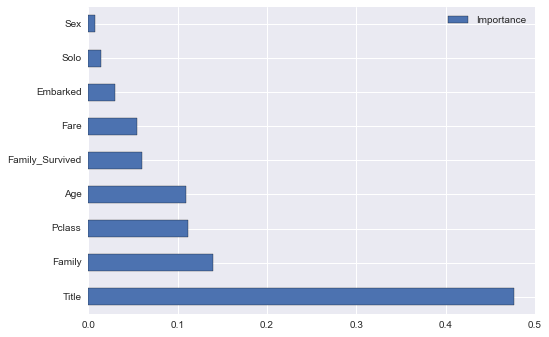

In [21]:
ret=plot_variable_importance(train_df.drop("Survived",axis=1), train_df["Survived"], 20)
sns.plt.show()
#lst=list(ret.index)
#lst.append("Survived")

In [24]:
pred=get_predict(autosklearn.classification.AutoSklearnClassifier())

[WARNING] [2017-06-24 23:48:44,032:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-06-24 23:48:44,032:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run3
You are already timing task: index_run4
You are already timing task: index_run4
You are already timing task: index_run4
You are already timing task: index_run4
You are already timing task: index_run4
You are already timing task: index_run4
You are already timing task: index_run4
You are already timing task: index_run4
You are already timing task: index_run4
You are already timing task: index_run4
You are already timing task: index_run4
You are already timing task: index_run4
You are already timing task: index_run5
You are already timing task: index_run5
You are already timing task: index_run5
You are already timing task: index_run5
You are already timing task: index_run5
You are already timing task: index_run5
You are already timing task: index_run5
You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run7
You are already timing task: index_run8


[WARNING] [2017-06-24 23:52:32,258:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-06-24 23:52:32,258:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run9
You are already timing task: index_run9
You are already timing task: index_run9
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run11
You are already timing task: index_run15
You are already timing task: index_run15
You are already timing task: index_run15
You are already timing task: index_run15
You are already timing task: index_run15
You are already timing task: index_run15
You are already timing task: index_run15
You are already timing task: index_run16
You are already timing task: index_run17
You are already timing task: index_run17
You are already timing task: index_run17
You are already timing task: index_run17
You are already timing task: index_run18
You are already timing task: index_run18
You are already timing task: index_run18
You are already timing task: index_run18
You are already timing task: index_run18
You are already timing task: index_run18
You are already tim

[WARNING] [2017-06-24 23:58:44,473:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-06-24 23:58:44,473:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run24
You are already timing task: index_run24
You are already timing task: index_run24
You are already timing task: index_run24
You are already timing task: index_run24
You are already timing task: index_run24
You are already timing task: index_run24
You are already timing task: index_run24
You are already timing task: index_run24
You are already timing task: index_run24
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already timing task: index_run26
You are already 

[WARNING] [2017-06-25 00:04:33,380:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-06-25 00:04:33,380:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already timing task: index_run29
You are already 

You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already 

[WARNING] [2017-06-25 00:36:02,909:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-06-25 00:36:02,909:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30


[WARNING] [2017-06-25 00:37:02,436:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-06-25 00:37:02,436:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already timing task: index_run30
You are already 

In [25]:
pred

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1,

In [26]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": pred
    })

In [27]:
submission.to_csv('../reports/auto_sklearn_submission.csv', index=False)